# Experiment 3 Model Results

## Imports & Set Up

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# enough with the warnings!
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

# PLOT STYLING
# Display plots in the notebook
%matplotlib inline 

#if you have jupyterthemes:
from jupyterthemes import jtplot
jtplot.style('grade3',context='paper', fscale=1.3)
jtplot.figsize(6, 6, 1.2)
# if you don't have jupyterthemes, but have seaborn you can use:
# sns.set(context='paper', rc={'figure.facecolor':'white'}, font_scale=1.7)

## Data Manipulation

In [2]:
def get_model_param(parameter,stats_csv):
    # Import and read data
    import pandas as pd
    import numpy as np
    df = pd.read_csv(stats_csv)
    
    # Clean up the DataFrame, and Add 'level' column
    df['param'] = df['Unnamed: 0']; # a more useful column name
    df = pd.DataFrame([df['param'], df['mean'], df['std']]) # only keep the bits we use
    df = df.T
    
    level = pd.Series(0, index=df.index)
    df['level'] = level # 0 ~ subject, 1 ~ group
    df.drop('level', axis=1)
    
    # Change the level for group parameters to 1 and remove group-level entries
    for i in range(len(df)):
        if '_' not in df.ix[i,'param'] or '.' not in df.ix[i,'param']:
            # All subject-level params have a '_' and '.' while group do not
            df.ix[i,'level'] = 1
    df = df[df['level'] == 1]
    mask = (df.param.str.startswith('%s'%parameter) & (df.param.str.find('_') == -1 ))
    df = df[mask]
    
    if parameter == 'v':
        # Create arrays to hold subj_idx, parameter value, condition and mean parameter estimate
        rps = np.array([])
        svs = np.array([])

        # fill arrays of sids, params and conds
        for i in df.index:    
            cond = str(df.ix[i, 'param'].split('(')[1].split(')')[0]) # condition
            rp = cond.split('.')[0]
            sv = cond.split('.')[1]

            # append to storage arrays
            rps = np.append(rps, rp)
            svs = np.append(svs, sv)    

        # Create a new DataFrame from the arrays (converted to Series)
        rps = pd.Series(rps)
        svs = pd.Series(svs)
        
        new_df = pd.DataFrame([rps, svs, df['mean'].values, df['std'].values],
                          index =['rwd_prob', 'stableVar', 'v_mean', 'v_std'])
    elif parameter =='z':
        # Create arrays to hold subj_idx, parameter value, condition and mean parameter estimate
        rps = np.array([])

        # fill arrays of sids, params and conds
        for i in df.index:    
            cond = str(df.ix[i, 'param'].split('(')[1].split(')')[0]) # condition
            rp = cond.split('.')[0]

            # append to storage arrays
            rps = np.append(rps, rp) 

        # Create a new DataFrame from the arrays (converted to Series)
        rps = pd.Series(rps)
        
        new_df = pd.DataFrame([rps, df['mean'].values, df['std'].values],
                          index =['rwd_prob', 'z_mean', 'z_std'])

    new_df = new_df.T
    
    return new_df

In [4]:
drift_df = get_model_param('v', 'exp3model_stats.csv' )
drift_df

,rwd_prob,stableVar,v_mean,v_std
0,0,0,-4.09581,0.428251
1,0,1,-3.67523,0.435538
2,0,2,-3.20573,0.428719
3,0,3,-2.32225,0.421554
4,1,0,-3.22875,0.433041
5,1,1,-3.30949,0.439597
6,1,2,-2.53163,0.40736
7,1,3,-1.61509,0.423987
8,2,0,0.955442,0.420439
9,2,1,1.5632,0.425426


In [5]:
bias_df = get_model_param('z', 'exp3model_stats.csv')
bias_df

,rwd_prob,z_mean,z_std
0,0,0.537196,0.015981
1,1,0.528508,0.0154928
2,2,0.463707,0.0157127
3,3,0.469534,0.0153911


In [7]:
# rename some values to be more useful
for i in range(len(drift_df.stableVar)):
    if drift_df.loc[i,'stableVar'] == '0':
        drift_df.loc[i,'stableVar'] = '$\sigma_s = \sigma_r$'
    elif drift_df.loc[i,'stableVar'] == '1':
        drift_df.loc[i,'stableVar'] = '$\sigma_s = 2\sigma_r$'
    elif drift_df.loc[i,'stableVar'] == '2':
       drift_df.loc[i,'stableVar'] = '$\sigma_s = 4\sigma_r$'
    elif drift_df.loc[i,'stableVar'] == '3':
        drift_df.loc[i,'stableVar'] = '$\sigma_s = 6\sigma_r$'

## Drift Rate

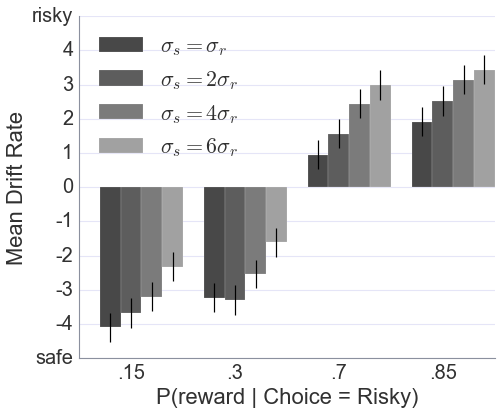

In [9]:
# code adapted from a stackoverflow answer to: https://stackoverflow.com/questions/42017049/seaborn-how-to-add-error-bars-on-a-grouped-barplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def grouped_barplot(df, cat,subcat, val , err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    cdict = sns.color_palette('Greys_d',4)
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values,
                color=cdict[i],ecolor='black')
    plt.xlabel('P(reward | Choice = Risky)', fontsize=22)
    plt.ylabel('Mean Drift Rate', fontsize=22)
    plt.yticks(np.linspace(-5,5,11),['safe','-4','-3','-2','-1','0','1','2','3','4','risky'], fontsize=20)
    plt.xticks(x,['.15','.3','.7','.85'], fontsize=20)
    plt.legend(loc='best',fontsize=22)
    sns.despine()
    plt.grid(axis='x')
    plt.savefig('exp3_drifts.eps')
    plt.savefig('exp3_drifts.svg')
    plt.show()


cat = "rwd_prob"
subcat = "stableVar"
val = "v_mean"
err = "v_std"
grouped_barplot(drift_df, cat, subcat, val, err )

## Bias

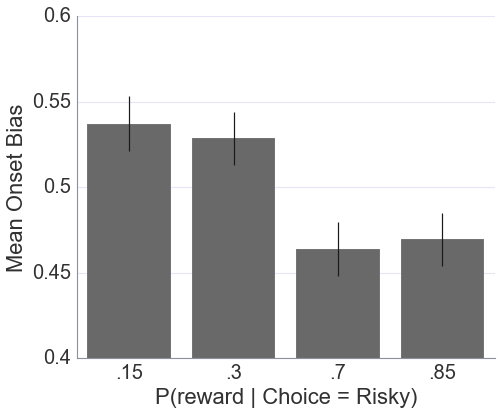

In [10]:
error_config = {'ecolor': '0.1'}
fig,ax = plt.subplots()
rects = plt.bar(bias_df.rwd_prob.astype(float)+.6, bias_df.z_mean.astype(float),.8, 
             yerr= bias_df.z_std.astype(float), error_kw=error_config,
            color='dimgray');

ax.set_xlabel('P(reward | Choice = Risky)', fontsize=22)
ax.set_ylabel('Mean Onset Bias', fontsize=22)

ax.set_ylim([0.4,0.6])


ax.set_xticks(np.linspace(1,4,4))
ax.set_yticks(np.linspace(0.4,0.6,5))

ax.set_xticklabels(['.15','.3','.7','.85'], fontsize=20)
ax.set_yticklabels(np.linspace(0.4,0.6,5),fontsize=20)

ax.grid(axis='x')

ax.legend()

sns.despine(top=True,right=True)

fig.savefig('exp3_bias.eps')
fig.savefig('exp3_bias.svg')